In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
from jax import jit
from jax import random
from jax import numpy as jnp
from jax.example_libraries import optimizers

import numpy as np

from matplotlib import pyplot as plt

from vae import HyperParams, build_vae
from datasets import get_mnist

In [3]:
mnist = get_mnist()

In [4]:
hps = HyperParams(encoder_width = 100, decoder_width = 100, latent_size = 10)
init_vae, run_vae = build_vae(hps)

In [5]:
def evaluate_idxs(params, idxs, rng):
  plt.figure(figsize=(10,30))
  for idx in idxs:
    img = mnist["train_x"][idx]
    elbo, logits, logpx, logpz, logqz = run_vae(params, img, rng=rng)
    recon = 1 / (1 + jnp.exp(-logits))

    print(idx, elbo, logpx, logpz, logqz)

    plt.subplot(len(idxs)*2, 2, idx*2+1)
    plt.imshow(np.array(img).reshape((28, 28)), cmap="gray")

    plt.subplot(len(idxs)*2, 2, idx*2+2)
    plt.imshow(np.array(recon).reshape((28, 28)), cmap="gray")

In [6]:
init_rng = random.PRNGKey(1)
_, init_params = init_vae(rng=init_rng, input_shape=(28 * 28,))

0 -821.23267 -820.2323 -14.322887 -13.322481
1 -838.00354 -835.9074 -15.418643 -13.322481
2 -844.68005 -844.0099 -13.992683 -13.322481
3 -982.2205 -979.5757 -15.967321 -13.322481
4 -913.23285 -909.96497 -16.590416 -13.322481


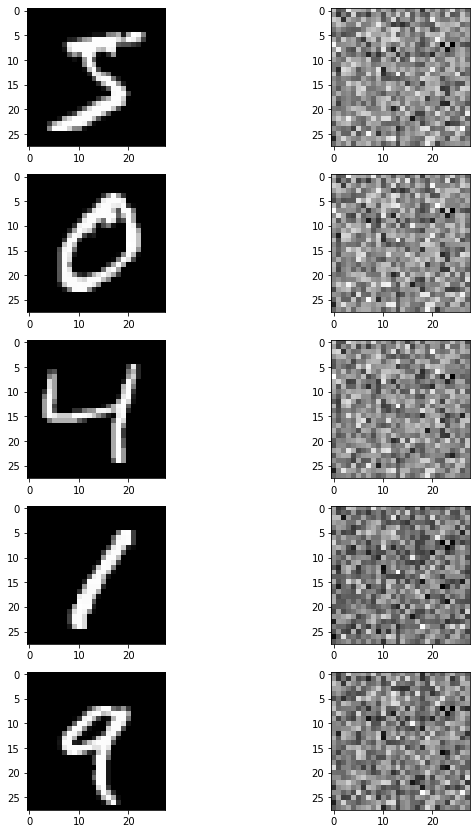

In [7]:
evaluate_idxs(init_params, range(5), rng=random.PRNGKey(2))

In [8]:
opt_init, opt_update, get_params = optimizers.adam(step_size=1e-4, eps=1e-4)

def loss_fn(rng, params, image):
  elbo, _, _, _, _ = run_vae(params, image, rng=rng)
  return -elbo

@jit
def run_epoch(rng, opt_state):
  images = mnist["train_x"][:2]
  num_images = images.shape[0]
  rngs = random.split(rng, num_images)

  def body_fn(opt_state, args):
    i, rng, image = args
    loss, g = jax.value_and_grad(loss_fn, argnums=1)(rng, get_params(opt_state), image)
    return opt_update(i, g, opt_state), loss

  res, losses = jax.lax.scan(body_fn, opt_state, (jnp.arange(num_images), rngs, images))
  return res, jnp.mean(losses)

In [9]:
num_epochs = 1500
opt_state = opt_init(init_params)
rng = random.PRNGKey(0)
for epoch in range(1, num_epochs+1):
  rng, epoch_rng = random.split(rng)
  opt_state, loss = run_epoch(rng, opt_state)
  if epoch % 300 == 0:
    print(epoch, loss)

300 615.4258
600 590.803
900 575.0957
1200 561.7375
1500 551.01196


0 -554.4395 -557.5524 -9.21585 -12.328735
1 -552.52527 -555.63727 -9.216721 -12.328735
2 -705.6941 -707.8468 -10.176044 -12.328735
3 -717.87604 -720.01404 -10.19071 -12.328735
4 -688.50397 -690.567 -10.265657 -12.328735


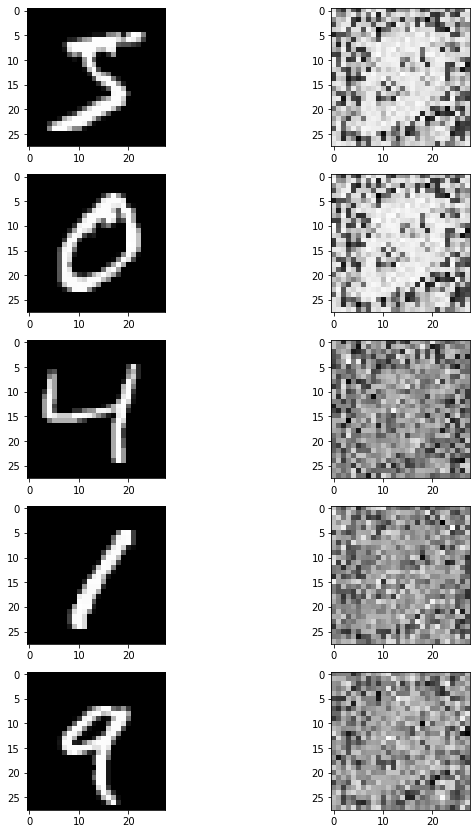

In [10]:
evaluate_idxs(get_params(opt_state), range(5), rng=random.PRNGKey(1))